### Programming and TensorFlow

- Please see the separate "Introduction to TensorFlow" notebook (from Machine Learning 1) if you are not familiar with TensorFlow

#### TensorFlow dtype
Due to interations between the CPU and GPU, TensorFlow is quite strict about the difference between single and double precision floating point numbers (`tf.float32` and `tf.float64`) respectively. To be safe, when declaring constants and variables in TensorFlow I always specify the `dtype` parameter by using defining `dtype` and `dtype_convert` at the top of the file. This allows, for example:
```python
t_vector_of_ones = tf.ones(shape=[5], dtype=dtype)
t_correct_precision = dtype_convert(t_not_correct_precision)
```
If you get tensorflow errors about `tf.float32` and `tf.float64` you probably have a constant declared using the wrong `dtype` somewhere in the computational graph.

#### Inverting the covariance matrix
Covariance matrices should be symmetric and positive definite - this means that they can be inverted using the Cholesky decomposition $K = L L^{\mathtt{T}}$ where $L$ is a square, lower triangular matrix. There is a TensorFlow operation `t_L_matrix = tf.cholesky(t_K_matrix)` that returns the matrix $L$. 

Once you have the decomposed matrix, it is efficient to evaluation the matrix inversion $A = K^{-1} B$ using the special solve operation `t_A_matrix = tf.cholesky_solve(t_L_matrix, t_B_matrix)`. 

If you need to perform the operation $A = L^{-1} B$ there is also a special operation `t_A_matrix = tf.matrix_triangular_solve(t_L_matrix, t_B_matrix)`.

Because the cholesky decomposition requires a positive definite matrix, we often add a small "jitter" diagonal matrix to try to improve the nummerical stability (in case the eigenvalues of the kernel become close to zero). For example we would perform the following:
```python
jitter = 1.0e-8
t_L_matrix = tf.cholesky(t_K_matrix + jitter * tf.eye(tf.shape(t_K_matrix)[0], dtype=dtype)
```
where `tf.shape()[0]` is returning the size of the kernel matrix to build a diagonal matrix identity matrix using `tf.eye()` (and we note that we specify the `dtype` of the matrix).

$$p(y \mid x) = \frac{p(x \mid y) p(y)}{p(x)}$$

\begin{align}
t &= f(x) + \varepsilon\\
\varepsilon &\sim \mathcal{N}(0, \sigma^2)
\end{align}


>\begin{align}
t &= f(x) + \varepsilon\\
\varepsilon &\sim \mathcal{N}(0, \sigma^2)
\end{align}

In [1]:
# Import statements..

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

dtype = tf.float64
dtype_convert = tf.to_double

np.random.seed(0)

## Squared Exponential Covariance Kernel

The following tensorflow code evaluates a squared exponential covariance in **vectorised** form (more efficient computation). It is good practice to check your tensorflow code as you write it using simple (but often inefficient) numpy code where we are less likely to introduce errors.

In [2]:
def get_lengthscale_euclid_sq_dist(t_X, t_Z, t_lengthscale):
    t_inv_lengthscale_squared = 1.0 / tf.square(t_lengthscale)
    xx = t_inv_lengthscale_squared * tf.reduce_sum(t_X * t_X, axis=1, keep_dims=True)
    zz = t_inv_lengthscale_squared * tf.reduce_sum(t_Z * t_Z, axis=1, keep_dims=True)
    return xx + tf.transpose(zz) - 2.0 * t_inv_lengthscale_squared * tf.matmul(t_X, t_Z, transpose_b=True)

def create_squared_exp_kernel(t_X1, t_X2, t_signal_variance, t_lengthscale):
    dist_x1x2_sq = get_lengthscale_euclid_sq_dist(t_X1, t_X2, t_lengthscale)
    return t_signal_variance * tf.exp(- 0.5 * dist_x1x2_sq)

Implement a function that calculates the squared exponential kernel in numpy using for loops and use it to check that the TensorFlow code operates correctly.

In [3]:
def numpy_squared_exp_kernel(X, signal_variance, lengthscale):
    
    # Add code using for loops to generate K(X, X)
    K = np.zeros([N,N])
    for i in range (N):
        for j in range (N): 
            a = X[i] - X[j]
            K[i,j] = signal_variance * np.exp(-1/(2*lengthscale*lengthscale)*np.square( X[i] - X[j]))
    return K

# Testing part:
lengthscale = 2.3
signal_variance = 1.4

N = 5
X = np.random.randn(N,1)
print(X)
tf.reset_default_graph()
with tf.Session() as session:
    t_lengthscale = tf.constant(lengthscale, dtype=dtype)
    t_signal_variance = tf.constant(signal_variance, dtype=dtype)
    t_X = tf.constant(X, dtype=dtype)
    
    t_K = create_squared_exp_kernel(t_X1=t_X, 
                                    t_X2=t_X, 
                                    t_signal_variance=t_signal_variance,
                                    t_lengthscale=t_lengthscale)
    
    print('TensorFlow K =\n', session.run(t_K))
    
    numpy_K = numpy_squared_exp_kernel(X=X, 
                                      signal_variance=signal_variance, 
                                      lengthscale=lengthscale)
    
    print('My numpy checking code K = \n', numpy_K)

[[1.76405235]
 [0.40015721]
 [0.97873798]
 [2.2408932 ]
 [1.86755799]]
Instructions for updating:
keep_dims is deprecated, use keepdims instead
TensorFlow K =
 [[1.4        1.17427272 1.32072556 1.37023329 1.39858306]
 [1.17427272 1.4        1.35639685 1.01634838 1.14219291]
 [1.32072556 1.35639685 1.4        1.20430393 1.2992705 ]
 [1.37023329 1.01634838 1.20430393 1.4        1.38167758]
 [1.39858306 1.14219291 1.2992705  1.38167758 1.4       ]]
My numpy checking code K = 
 [[1.4        1.17427272 1.32072556 1.37023329 1.39858306]
 [1.17427272 1.4        1.35639685 1.01634838 1.14219291]
 [1.32072556 1.35639685 1.4        1.20430393 1.2992705 ]
 [1.37023329 1.01634838 1.20430393 1.4        1.38167758]
 [1.39858306 1.14219291 1.2992705  1.38167758 1.4       ]]


## GP Regression Model

The following is TensorFlow code that implements a regression GP model with a Gaussian likelihood (as per the lecture notes). Look through to see how the function works and correlate the code with the mathematical expressions for the marginal log likelihood and the predictive posterior code. Note that we optimise the **negative log likelihood** in TensorFlow since the optimiser **minimises** the objective function.

In [4]:
# A wrapper function to create a real number variable (-infinity, infinity)
# with an initial value that will be optimised by tensorflow.
def create_real_variable(initial_value):
    return tf.Variable(initial_value, dtype=dtype)

# A wrapper function to create a positive variable (0, infinity) by
# taking the exp() of a real number - this will map the real range to
# the set of positive numbers.
def create_positive_variable(initial_value):
    assert initial_value > 0.0
    return tf.exp(tf.Variable(np.log(initial_value), dtype=dtype))

# A Gaussian Process class to keep all the parts of the model we need
# grouped together
class GP:
    def __init__(self,
                 description,
                 t_objective,
                 create_prediction_function,
                 t_prediction_placeholder,
                 t_prediction_mean,
                 t_prediction_var,
                 t_input=None,
                 t_output=None,
                 hyperparameter_dict={}):

        self._description = description
        self._t_objective = t_objective
        self._create_prediction_function = create_prediction_function
        self._t_prediction_placeholder = t_prediction_placeholder
        self._t_prediction_mean = t_prediction_mean
        self._t_prediction_var = t_prediction_var
        self._t_input = t_input
        self._t_output = t_output
        self._hyperparameter_dict = hyperparameter_dict

    @property
    def description(self): return self._description

    @property
    def t_objective(self): return self._t_objective

    @property
    def t_prediction_placeholder(self): return self._t_prediction_placeholder

    @property
    def t_prediction_mean(self): return self._t_prediction_mean

    @property
    def t_prediction_var(self): return self._t_prediction_var

    @property
    def t_input(self): return self._t_input

    @property
    def t_output(self): return self._t_output

    @property
    def hyperparameter_dict(self): return self._hyperparameter_dict

    def create_prediction(self, tf_input):
        return self._create_prediction_function(tf_input)
    

# Create a GP regression model by specifying the input and output data, as (N x 1) matrices,
# and the initial values for the hyperparameters (these will be turned into tensorflow variables
# and optimised).
def create_gp(input_data, 
              output_data, 
              initial_signal_variance,
              initial_lengthscale,
              initial_sigma_noise_sq):

    # Constant training data in tensorflow
    t_X = tf.constant(input_data, dtype=dtype)
    t_Y = tf.constant(output_data, dtype=dtype)

    t_N = tf.shape(t_Y)[0]
    t_D = tf.shape(t_Y)[1]
    t_Q = tf.shape(t_X)[1]
    jitter = 1.0e-8

    # Create variables for hyperparamers
    t_signal_variance = create_positive_variable(initial_signal_variance)
    t_lengthscale = create_positive_variable(initial_lengthscale)
    t_sigma_noise_sq = create_positive_variable(initial_sigma_noise_sq)
    
    hyperparameter_dict = {'signal_variance': t_signal_variance,
                           'lengthscale': t_lengthscale,
                           'sigma_noise_squared': t_sigma_noise_sq}
    
    # Create a lambda function to ensure we use the same hyperparameters
    # when be create the different kernels..
    kernel_creation_function = lambda t_X1, t_X2: \
        create_squared_exp_kernel(t_X1=t_X1, 
                                  t_X2=t_X2,
                                  t_lengthscale=t_lengthscale,
                                  t_signal_variance=t_signal_variance)

    # Create the training data covariance matrix + noise identity matrix
    #
    # NOTE: We include the jitter term to improve nummerical stability
    #
    t_K_xx = kernel_creation_function(t_X1=t_X, t_X2=t_X) \
        + (t_sigma_noise_sq + jitter) * tf.eye(t_N, dtype=dtype)

    # Take the cholesky decomposition of K = L L^T to make it easy to calculate 
    # the inverse of K and the log determinant of K. This relies on K being a 
    # positive definite covariance matrix.
    t_L_xx = tf.cholesky(t_K_xx)

    # The log determinant of K is twice the sum of the log of the diagonal of the
    # cholesky matrix
    t_log_det = 2.0 * tf.reduce_sum(tf.log(tf.diag_part(t_L_xx)))

    # We can calculate the data fit term by using the cholesky matrix L to
    # invert the covariance matrix efficiently using the matrix triangular solve
    # operation. 
    #
    # Tr[K^-1 Y Y^T] = Tr[Y^T (L L^T)^-1 Y] = Tr[(Y^T L^-T) (L^-1 Y)] = sum((L^-1 Y)^2)
    #
    t_Kinv_YYtranspose = 0.5 * tf.reduce_sum(tf.square(
        tf.matrix_triangular_solve(t_L_xx, t_Y, lower=True)))

    # Add a loose prior on the noise variance
    t_noise_prior = + 0.5 * tf.square(tf.log(t_sigma_noise_sq))
    
    # Add loose priors on the kernel hyperparameters
    t_hyper_prior = + 0.5 * tf.square(tf.log(t_signal_variance)) \
                    + 0.5 * tf.square(tf.log(t_lengthscale)) 

    half_log_two_pi = tf.constant(0.5 * np.log(2.0 * np.pi), dtype=dtype)

    # Evaluate the NEGATIVE (since we will minimise) marginal log likelihood as
    # the objective for training the hyperparameters
    t_neg_log_likelihood = half_log_two_pi * dtype_convert(t_D) * dtype_convert(t_N) \
                         + 0.5 * dtype_convert(t_D) * t_log_det \
                         + t_Kinv_YYtranspose + t_hyper_prior + t_noise_prior

    def create_prediction(tf_input):
        # Invert using the cholesky decomposition of the kernel
        t_Kinv_Y = tf.cholesky_solve(t_L_xx, t_Y)
        
        # Calculate the kernel from the input to the training data
        t_K_x_X = kernel_creation_function(t_X1=tf_input, t_X2=t_X)
        
        # Get the predicitive mean
        t_y_mean = tf.matmul(t_K_x_X, t_Kinv_Y)
        
        t_K_x_x_diag = tf.diag_part(kernel_creation_function(t_X1=tf_input, t_X2=tf_input)) \
            + t_sigma_noise_sq * tf.ones([tf.shape(tf_input)[0]], dtype=dtype)

        # Get the predicitve variance
        t_y_var = t_K_x_x_diag - tf.reduce_sum(tf.square(
            tf.matrix_triangular_solve(t_L_xx, tf.transpose(t_K_x_X))), axis=0)
        
        # Make sure a N* x 1 matrix (where N* = number of test inputs)
        t_y_var = t_y_var[:, tf.newaxis]

        # Return the predicitve mean and variance
        return t_y_mean, t_y_var

    # A placeholder for providing different test data after training. See the introduction
    # to tensorflow for details on how the placeholders work
    t_prediction_placeholder = tf.placeholder(dtype=dtype)
    t_prediction_mean, t_prediction_var = create_prediction(t_prediction_placeholder)

    gp = GP(description='Gaussian Process',
            t_objective=t_neg_log_likelihood,
            create_prediction_function=create_prediction,
            t_prediction_placeholder=t_prediction_placeholder,
            t_prediction_mean=t_prediction_mean,
            t_prediction_var=t_prediction_var,
            t_input=t_X,
            t_output=t_Y,
            hyperparameter_dict=hyperparameter_dict)

    return gp


# Print out the current values of the hyperparameters
def print_hyperparameters(gp, session):
    for (k, v) in gp.hyperparameter_dict.items():
        print('{} = {:.6}'.format(k, session.run(v)))
    print('')


# Plot the predicitve posterior for the provide input values (num_test_points x 1 matrix) 
def plot_gp_predictions(gp, session, input_values):
    # Ensure N* x 1 input variable
    if input_values.ndim == 1:
        input_values = input_values[:,np.newaxis]
    
    feed_dict = {gp.t_prediction_placeholder: input_values}
    
    pred_mean, pred_var = session.run((gp.t_prediction_mean, 
                                       gp.t_prediction_var), 
                                      feed_dict=feed_dict)
    
    plt.figure(figsize=[12,6])
    plt.plot(session.run(gp.t_input), session.run(gp.t_output), 'k.')
    plt.plot(input_values, pred_mean, 'r-')
    plt.plot(input_values, pred_mean + 2.0 * np.sqrt(pred_var), 'r:')
    plt.plot(input_values, pred_mean - 2.0 * np.sqrt(pred_var), 'r:')
    plt.grid(True)

    
    

Run the GP model on the following toy dataset to ensure everything is working.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Before Optimisation:
signal_variance = 1.0
lengthscale = 1.0
sigma_noise_squared = 1.0

  opt iter     0: objective = 24.265875491851364
  opt iter   200: objective = 6.282378000976794
  opt iter   400: objective = 6.282377976574923
  opt iter   600: objective = 6.28237797657487
  opt iter   800: objective = 6.28237797657488
  opt iter  1000: objective = 6.282377976574873
  opt iter  1200: objective = 6.282379085330999
  opt iter  1400: objective = 6.282377976574896
  opt iter  1600: objective = 6.283388589103232
  opt iter  1800: objective = 6.282377976575139
Final iter  1999: objective = 6.282377976576358

After Optimisation:
signal_variance = 0.958689
lengthscale = 0.590215
sigma_noise_squared = 0.0145719



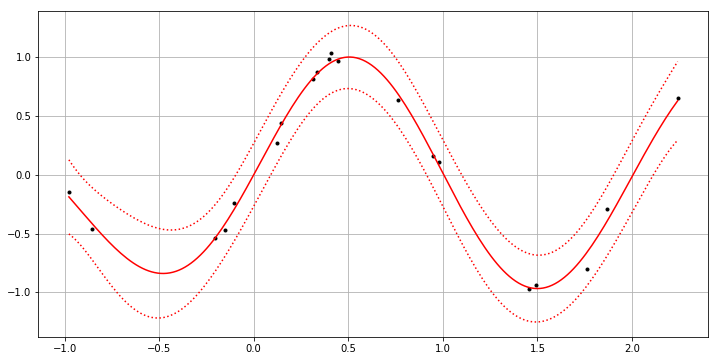

In [5]:
tf.reset_default_graph()

N = 20

np.random.seed(0)

input_data = np.random.randn(N,1)
output_data = np.sin(np.pi * input_data) + 0.05 * np.random.randn(N,1)

gp = create_gp(input_data=input_data, 
               output_data=output_data, 
               initial_signal_variance=1.0,
               initial_lengthscale=1.0,
               initial_sigma_noise_sq=1.0)

with tf.Session() as session:
    feed_dict = {}

    t_objective = gp.t_objective
    learning_rate = 0.1
    num_iterations = 2000

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(t_objective)
    
    session.run(tf.global_variables_initializer())
    
    print('Before Optimisation:')
    print_hyperparameters(gp, session)

    refresh_iter = int(np.ceil(num_iterations / 10))
    for i in range(num_iterations):
        opt, cost = session.run((optimizer, t_objective),
                                feed_dict=feed_dict)
        if (i % refresh_iter) == 0:
            print('  opt iter {:5}: objective = {}'.format(i, cost))

    print('Final iter {:5}: objective = {}\n'.format(i, cost))
    
    print('After Optimisation:')
    print_hyperparameters(gp, session)
    
    input_values = np.linspace(np.min(input_data), np.max(input_data), 200)
    plot_gp_predictions(gp, session, input_values)



## Bike Traffic Count Dataset

The following data is take from the UK Department of Transport figures counting how many cyclists crossed Vauxhall Bridge over Monday to Friday (week starting 31st July 2008). We note that the counts per hour are integers.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,31,70,186,351,194,65,23,30,29,22,31,34,59,68,41,23,14,5,4
1,40,64,203,406,201,59,26,32,36,23,31,39,66,73,52,27,15,11,4
2,29,62,194,347,168,58,35,41,31,29,37,39,70,76,30,16,13,12,8
3,35,55,155,318,166,51,43,34,40,21,25,34,52,59,31,21,8,13,5
4,33,44,121,243,139,48,35,44,34,37,27,35,44,52,27,21,16,10,7


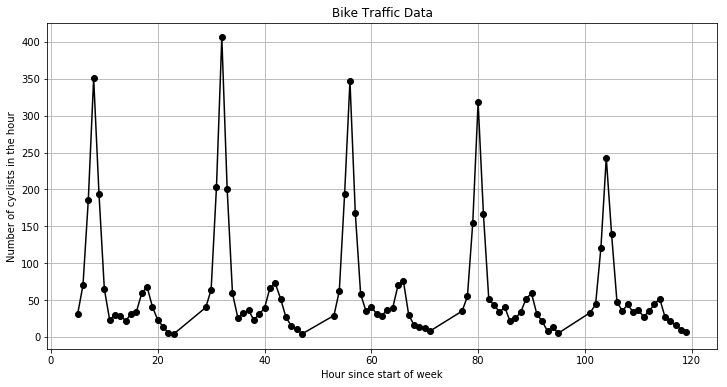

In [6]:
bike_data = pd.read_csv('traffic_data_week_2008_07_31.csv')
bike_data = bike_data.drop([5,6])
counts = bike_data.as_matrix().flatten()
times = np.zeros(bike_data.shape)
for n, r in bike_data.iterrows():
    times[n,:] = bike_data.columns.astype(np.float64) + (n*24)
times = times.flatten()

bike_counts = counts[:,np.newaxis]
bike_times = times[:,np.newaxis]

plt.figure(figsize=[12,6])
plt.plot(bike_times, bike_counts, 'ko-')
plt.grid(True)
plt.title('Bike Traffic Data')
plt.xlabel('Hour since start of week')
plt.ylabel('Number of cyclists in the hour')

bike_data

Run the GP code with a squared exponential kernel on the bike count data. 

Before Optimisation:
signal_variance = 1.0
lengthscale = 1.0
sigma_noise_squared = 1.0

  opt iter     0: objective = 170865.7284377394
  opt iter   200: objective = 1974.7006453601464
  opt iter   400: objective = 1002.7616672497778
  opt iter   600: objective = 769.0917894566505
  opt iter   800: objective = 687.3504092835101
  opt iter  1000: objective = 653.8017301622698
  opt iter  1200: objective = 638.9149470729836
  opt iter  1400: objective = 632.0909944106802
  opt iter  1600: objective = 628.9576378086277
  opt iter  1800: objective = 627.5484481436603
Final iter  1999: objective = 626.9384260486811

After Optimisation:
signal_variance = 162.428
lengthscale = 4.22954
sigma_noise_squared = 6687.03



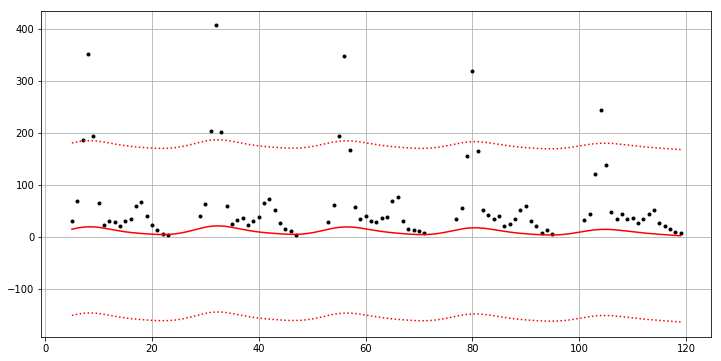

In [7]:
tf.reset_default_graph()

N = 20

np.random.seed(0)

input_data = bike_times
output_data = bike_counts

gp = create_gp(input_data=input_data, 
               output_data=output_data, 
               initial_signal_variance=1.0,
               initial_lengthscale=1.0,
               initial_sigma_noise_sq=1.0)

with tf.Session() as session:
    feed_dict = {}

    t_objective = gp.t_objective
    learning_rate = 0.1
    num_iterations = 2000

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(t_objective)
    
    session.run(tf.global_variables_initializer())
    
    print('Before Optimisation:')
    print_hyperparameters(gp, session)

    refresh_iter = int(np.ceil(num_iterations / 10))
    for i in range(num_iterations):
        opt, cost = session.run((optimizer, t_objective),
                                feed_dict=feed_dict)
        if (i % refresh_iter) == 0:
            print('  opt iter {:5}: objective = {}'.format(i, cost))

    print('Final iter {:5}: objective = {}\n'.format(i, cost))
    
    print('After Optimisation:')
    print_hyperparameters(gp, session)
    
    input_values = np.linspace(np.min(input_data), np.max(input_data), 200)
    plot_gp_predictions(gp, session, input_values)



**Comment:**

Because the covariance is infinitely differentiable, this can make GP with covariance function has all the mean-square derivative, thus the graphic is very smooth. The number of turning points of output is random, but it si controlled by the length scale value. Generally, the lengthscale indicates the distance between turning points of output. 

Although exponential kernel functions are thought can modeling many physical processes, this assumption of strong smoothness is unrealistic in real example. However, exponential squared is still the most widely used kernel in the kernel machine field.

## Switch to using periodic kernel

Implement the periodic kernel and copy and paste the GP code from above, modifying it to use your new periodic kernel.

**The periodic kernel is defined as:**

$$
K(x_i, x_j) = \sigma_{\mathrm{f}}^{2} \exp\!\left( - 2 \gamma \left[\sin\left(\frac{\pi}{T} \sqrt{\|x_i - x_j\|^2} \right)\right]^2 \right)
$$

**Hyperparameters:**
- Signal variance $\sigma_{\mathrm{f}}^2$ (positive)
- Inverse Lengthscale $\gamma = 1 / \ell^2$ (positive)
- Period $T$ (positive)

In [8]:
def create_periodic_kernel(t_X1, t_X2, t_signal_variance, t_gamma, t_period):
    xx = tf.reduce_sum(t_X1 * t_X1, axis=1, keep_dims=True)
    zz = tf.reduce_sum(t_X2 * t_X2, axis=1, keep_dims=True)
    input_square = xx + tf.transpose(zz) - 2.0 *  tf.matmul(t_X1, t_X2, transpose_b=True)
    
    re_period = np.pi / t_period
    sin_inner = re_period * tf.sqrt(input_square)
    sin2 = tf.square(tf.sin(sin_inner))

    return t_signal_variance * tf.exp(- 2 * t_gamma * sin2)

# Modify this function as appropriate..
def create_periodic_gp(input_data, 
                       output_data, 
                       initial_signal_variance,
                       initial_gamma,
                       initial_period,
                       initial_sigma_noise_sq):

    # Constant training data in tensorflow
    t_X = tf.constant(input_data, dtype=dtype)
    t_Y = tf.constant(output_data, dtype=dtype)

    t_N = tf.shape(t_Y)[0]
    t_D = tf.shape(t_Y)[1]
    t_Q = tf.shape(t_X)[1]
    jitter = 1.0e-8

    # Create variables for hyperparamers
    t_signal_variance = create_positive_variable(initial_signal_variance)
    t_gamma = create_positive_variable(initial_gamma)
    t_period = create_positive_variable(initial_period)
#     t_lengthscale = create_positive_variable(initial_lengthscale)
    t_sigma_noise_sq = create_positive_variable(initial_sigma_noise_sq)
    
    hyperparameter_dict = {'signal_variance': t_signal_variance,
                           'gamma': t_gamma,
                           't_period':t_period,
                           'sigma_noise_squared': t_sigma_noise_sq}
    
    # Create a lambda function to ensure we use the same hyperparameters
    # when be create the different kernels..
    kernel_creation_function = lambda t_X1, t_X2: \
        create_periodic_kernel(t_X1=t_X1, 
                                  t_X2=t_X2,
                                  t_gamma = t_gamma, 
                                  t_period = t_period,
                                  t_signal_variance=t_signal_variance)

    # Create the training data covariance matrix + noise identity matrix
    #
    # NOTE: We include the jitter term to improve nummerical stability
    #
    t_K_xx = kernel_creation_function(t_X1=t_X, t_X2=t_X) \
        + (t_sigma_noise_sq + jitter) * tf.eye(t_N, dtype=dtype)

    # Take the cholesky decomposition of K = L L^T to make it easy to calculate 
    # the inverse of K and the log determinant of K. This relies on K being a 
    # positive definite covariance matrix.
    t_L_xx = tf.cholesky(t_K_xx)

    # The log determinant of K is twice the sum of the log of the diagonal of the
    # cholesky matrix
    t_log_det = 2.0 * tf.reduce_sum(tf.log(tf.diag_part(t_L_xx)))

    # We can calculate the data fit term by using the cholesky matrix L to
    # invert the covariance matrix efficiently using the matrix triangular solve
    # operation. 
    #
    # Tr[K^-1 Y Y^T] = Tr[Y^T (L L^T)^-1 Y] = Tr[(Y^T L^-T) (L^-1 Y)] = sum((L^-1 Y)^2)
    #
    t_Kinv_YYtranspose = 0.5 * tf.reduce_sum(tf.square(
        tf.matrix_triangular_solve(t_L_xx, t_Y, lower=True)))

    # Add a loose prior on the noise variance
    t_noise_prior = + 0.5 * tf.square(tf.log(t_sigma_noise_sq))
    
    # Add loose priors on the kernel hyperparameters
    t_hyper_prior = + 0.5 * tf.square(tf.log(t_signal_variance)) \
                    + 0.5 * tf.square(tf.log(t_gamma)) \
                    + 0.5 * tf.square(tf.log(t_period))

    half_log_two_pi = tf.constant(0.5 * np.log(2.0 * np.pi), dtype=dtype)

    # Evaluate the NEGATIVE (since we will minimise) marginal log likelihood as
    # the objective for training the hyperparameters
    t_neg_log_likelihood = half_log_two_pi * dtype_convert(t_D) * dtype_convert(t_N) \
                         + 0.5 * dtype_convert(t_D) * t_log_det \
                         + t_Kinv_YYtranspose + t_hyper_prior + t_noise_prior

    def create_prediction(tf_input):
        # Invert using the cholesky decomposition of the kernel
        t_Kinv_Y = tf.cholesky_solve(t_L_xx, t_Y)
        
        # Calculate the kernel from the input to the training data
        t_K_x_X = kernel_creation_function(t_X1=tf_input, t_X2=t_X)
        
        # Get the predicitive mean
        t_y_mean = tf.matmul(t_K_x_X, t_Kinv_Y)
        
        t_K_x_x_diag = tf.diag_part(kernel_creation_function(t_X1=tf_input, t_X2=tf_input)) \
            + t_sigma_noise_sq * tf.ones([tf.shape(tf_input)[0]], dtype=dtype)

        # Get the predicitve variance
        t_y_var = t_K_x_x_diag - tf.reduce_sum(tf.square(
            tf.matrix_triangular_solve(t_L_xx, tf.transpose(t_K_x_X))), axis=0)
        
        # Make sure a N* x 1 matrix (where N* = number of test inputs)
        t_y_var = t_y_var[:, tf.newaxis]

        # Return the predicitve mean and variance
        return t_y_mean, t_y_var

    # A placeholder for providing different test data after training. See the introduction
    # to tensorflow for details on how the placeholders work
    t_prediction_placeholder = tf.placeholder(dtype=dtype)
    t_prediction_mean, t_prediction_var = create_prediction(t_prediction_placeholder)

    gp = GP(description='Periodic Gaussian Process',
            t_objective=t_neg_log_likelihood,
            create_prediction_function=create_prediction,
            t_prediction_placeholder=t_prediction_placeholder,
            t_prediction_mean=t_prediction_mean,
            t_prediction_var=t_prediction_var,
            t_input=t_X,
            t_output=t_Y,
            hyperparameter_dict=hyperparameter_dict)

    return gp

*Run the code below after writing the functions above..*

Before Optimisation:
signal_variance = 1.0
gamma = 1.0
t_period = 24.0
sigma_noise_squared = 1.0

  opt iter     0: objective = 136410.78567727082
  opt iter   200: objective = 1257.7561801080114
  opt iter   400: objective = 862.4104264372631
  opt iter   600: objective = 702.4820208741633
  opt iter   800: objective = 621.8596067278602
  opt iter  1000: objective = 577.1817013052631
  opt iter  1200: objective = 550.8881167804778
  opt iter  1400: objective = 534.7834972817195
  opt iter  1600: objective = 524.6639594581034
  opt iter  1800: objective = 518.2110616509996
Final iter  1999: objective = 514.0875809355224

After Optimisation:
signal_variance = 3367.55
gamma = 13.7982
t_period = 24.0078
sigma_noise_squared = 166.431



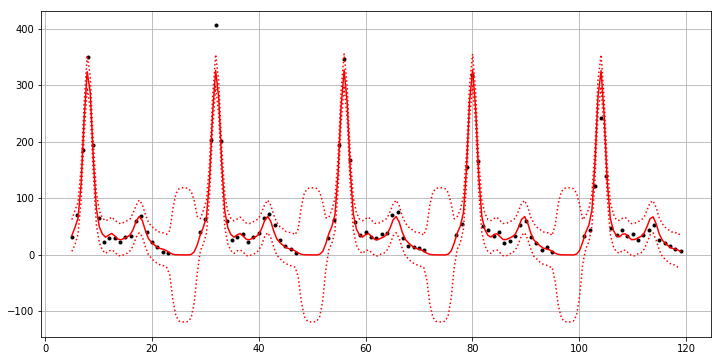

In [9]:
tf.reset_default_graph()

N = 20

np.random.seed(0)

input_data = bike_times
output_data = bike_counts

gp = create_periodic_gp(input_data=input_data, 
                        output_data=output_data, 
                        initial_signal_variance=1.0,
                        initial_gamma=1.0,
                        initial_period=24.0,
                        initial_sigma_noise_sq=1.0)

with tf.Session() as session:
    feed_dict = {}

    t_objective = gp.t_objective
    learning_rate = 0.1
    num_iterations = 2000

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(t_objective)
    
    session.run(tf.global_variables_initializer())
    
    print('Before Optimisation:')
    print_hyperparameters(gp, session)

    refresh_iter = int(np.ceil(num_iterations / 10))
    for i in range(num_iterations):
        opt, cost = session.run((optimizer, t_objective),
                                feed_dict=feed_dict)
        if (i % refresh_iter) == 0:
            print('  opt iter {:5}: objective = {}'.format(i, cost))

    print('Final iter {:5}: objective = {}\n'.format(i, cost))
    
    print('After Optimisation:')
    print_hyperparameters(gp, session)
    
    input_values = np.linspace(np.min(input_data), np.max(input_data), 200)
    plot_gp_predictions(gp, session, input_values)

__comment:__

Implement the peridic kernel has increased accuracy of predictions. Cause there add a new parameter initial_period, which given value equal to 24.0. This value is exactly match the time period as recorded in Bike Traffic Count dataset. The parameter Period T of sin function also can modify the distance betweent the x locations, result in changing the smoothness of output. Therefore, the perdic kernel performance better then squared exponential kernel.

## Gaussian Process Regression with Poisson Likelihood

The Poisson distribution is a probability distribution over counts within a fixed time period (positive integer values). The likelihood function is defined in terms of a positive rate parameter $\lambda > 0$ as

$$
p(y) = \frac{\lambda^{y} \exp(\lambda)}{y!}, \; y \in [0,1,2,3,\dots]
$$

In a similar manner to the GP for binary classification (Bernoulli likelihood) in the lecture notes, we can define a GP with a Poisson likelihood

$$
p(Y, f \mid X, \theta) = p(Y \mid f) \, p(f \mid X, \theta)
$$

where the $\lambda$ parameter in the Poisson likelihood is a function of $f$. Assuming iid data we have

$$
p(Y \mid X) = \prod_{n=1}^{N} \frac{{\lambda(f_n)}^{y_n} \exp(\lambda(f_n))}{y_n!}
$$

We put a GP prior over $f$

$$
p(f \mid X, \theta) = \mathcal{N}(f \mid 0, \kappa(X,X;\theta)
$$

however this makes the value of $f$ a real number. We map this to a positive number through the exponential function such that

$$
\lambda(f_n) = \exp(f_n) \; \Rightarrow \; \lambda(f_n) \in \mathcal{R}^{+} 
$$

To calculate the marginal log likelihood we must integrate out the function parameters $f$ such that

$$
\log p(Y \mid X, \theta) = \log \int p(Y \mid f) \, p(f \mid X, \theta) \mathrm{d}f
$$

As for the classification GP, we cannot perform this operation in closed form so we use a variational approximation 

$$
q(f) = \prod_n \mathcal{N}(f_n \mid \mu_n, \sigma^2)
$$

with a mean variational parameter $\mu_n$ for each $f_n$ and a shared variance $\sigma^2$.

The variational lower bound can then be defined as 

$$
\mathcal{L} =  \sum_n \mathbb{E}_{q(f_n)}\!\left[ \log p(y_n \mid f_n) \right] - \mathrm{KL}\big[ q(f) \,\|\, p(f\mid X, \theta) \big]
$$

We now look at the two terms in the lower bound and the next task is to derive expressions related to the expectation and the KL divergence.


*Task:* Find an expression for the KL divergence between two **univariate** Gaussian distributions:
    
$$
\mathrm{KL}\left[\mathcal{N}(x \mid \mu_0, \sigma_0^2) \| \mathcal{N}(x \mid \mu_1, \sigma_1^2) \right] =
\int \mathcal{N}(x \mid \mu_0, \sigma_0^2) \log \frac{\mathcal{N}(x \mid \mu_0, \sigma_0^2)}{\mathcal{N}(x \mid \mu_1, \sigma_1^2)} \mathrm{d}x
$$

**Enter the derivation in the Markdown box below..**


$$
\mathrm{KL}\left[\mathcal{N}(x \mid \mu_0, \sigma_0^2) \| \mathcal{N}(x \mid \mu_1, \sigma_1^2) \right] =
\int \mathcal{N}(x \mid \mu_0, \sigma_0^2) \log \frac{\mathcal{N}(x \mid \mu_0, \sigma_0^2)}{\mathcal{N}(x \mid \mu_1, \sigma_1^2)} \mathrm{d}x
$$
__here, let__

$q(x) = \mathcal{N}(x \mid \mu_0, \sigma_0^2)$

$p(x) =  \mathcal{N}(x \mid \mu_1, \sigma_1^2)$



$$
⇒ \int q(x)[ \log \frac{1}{\sqrt{2\pi\sigma_0^2}}e^\frac{-(x-\mu_0)^2}{2\sigma_0^2} - \log \frac{1}{\sqrt{2\pi\sigma_1^2}}e^\frac{-(x-\mu_1)^2}{2\sigma_1^2}]\mathrm{d}x
$$

$$
= \int q(x)[ \log\frac{\sigma_1}{\sigma_0} - \frac{(x-\mu_0)^2}{2\sigma_0^2}\log{e} + \frac{(x-\mu_1)^2}{2\sigma_1^2}\log{e}]\mathrm{d}x
$$

$$
= \int q(x)[ \log\frac{\sigma_1}{\sigma_0} - \frac{(x-\mu_0)^2}{2\sigma_0^2} + \frac{(x-\mu_1)^2}{2\sigma_1^2}]\mathrm{d}x
$$

$$
= \int {\log\frac{\sigma_1}{\sigma_0} q(x)\mathrm{d}x} - {\frac{1}{2\sigma_0^2}\int (x-\mu_0)^2}q(x)\mathrm{d}x +{\frac{1}{2\sigma_1^2}\int (x-\mu_1)^2}q(x)\mathrm{d}x
$$
__since :__
$(x-\mu_0)^2 = \sigma_0^2$

$$
⇒ \log\frac{\sigma_1}{\sigma_0} - \frac{1}{2\sigma_0^2}\sigma_0^2+{\frac{1}{2\sigma_1^2}\int (x-\mu_1 +\mu_0-\mu_0)^2}q(x)\mathrm{d}x
$$

$$
= \log\frac{\sigma_1}{\sigma_0} - \frac{1}{2}+{\frac{1}{2\sigma_1^2}\int [(x-\mu_0) -(\mu_1-\mu_0)]^2}q(x)\mathrm{d}x
$$

$$
= \log\frac{\sigma_1}{\sigma_0} - \frac{1}{2}+{\frac{1}{2\sigma_1^2}\int [(x-\mu_0)^2 -2(x-\mu_0)(\mu_1-\mu_0)+(\mu_1-\mu_0)^2]}q(x)\mathrm{d}x
$$

$$
= \log\frac{\sigma_1}{\sigma_0} - \frac{1}{2}+{\frac{1}{2\sigma_1^2}\int [\sigma_0^2 +(\mu_1-\mu_0)^2]}q(x)\mathrm{d}x
$$

$$
= \log\frac{\sigma_1}{\sigma_0} - \frac{1}{2}+ \frac{\sigma_0^2}{2\sigma_1^2} +{\frac{(\mu_1-\mu_0)^2}{2\sigma_1^2}}
$$

The corresponding KL divergence for **multivariate** Gaussians is given by

$$
\mathrm{KL}\left[\mathcal{N}(x \mid \mu_0, \Sigma_0) \| \mathcal{N}(x \mid \mu_1, \Sigma_1) \right] = 
\frac{1}{2} \left( \mathrm{Tr}[\Sigma_1^{-1} \Sigma_0] + (\mu_1 - \mu_0)^{T}\Sigma_1^{-1}(\mu_1 - \mu_0) - N + \log \frac{\det \Sigma_1}{\det \Sigma_0} \right), \;\text{for}\; x \in \mathbb{R}^{N}
$$

Prove the following expression is the KL divergence between the approximating distrbution and our Gaussian process prior on $f$

$$
\mathrm{KL}\left[ q(f) \| p(f\mid X, \theta) \right] = \frac{1}{2} \left( \mathrm{Tr}[K^{-1}(\sigma^2 I + \mu \mu^T)] - N + \log \det K - N \log{\sigma^2} \right), \; K = \kappa(X,X;\theta)
$$

**Enter the derivation in the Markdown box below..**

$$
\mathrm{KL}\left[\mathcal{N}(x \mid \mu_0, \Sigma_0) \| \mathcal{N}(x \mid \mu_1, \Sigma_1) \right] = 
\frac{1}{2} \left( \mathrm{Tr}[\Sigma_1^{-1} \Sigma_0] + (\mu_1 - \mu_0)^{T}\Sigma_1^{-1}(\mu_1 - \mu_0) - N + \log \frac{\det \Sigma_1}{\det \Sigma_0} \right)
$$

__here, let__

$
q(f) = \mathcal{N}(x \mid \mu, \sigma^2)
$

$
p(f∣𝑋,𝜃) =  \mathcal{N}(x \mid 0, K)
$

$
\Sigma_0 = \sigma^2
$

$
\Sigma_1 = K
$

__therefore__

$$
⇒ \frac{1}{2}(\mathrm{Tr}[K^{-1} \sigma^2] + (0 - \mu)^{T}K^{-1}(0 - \mu) - N + \log \det K - \log \det\sigma^2
$$

$$
= \frac{1}{2}(\mathrm{Tr}[K^{-1} \sigma^2 I] + \mathrm{Tr}[K^{-1}\mu\mu^{T}] - N + \log \det K -\log \sigma^{2N}
$$
$$
=\frac{1}{2} \left( \mathrm{Tr}[K^{-1}(\sigma^2 I + \mu \mu^T)] - N + \log \det K - N \log{\sigma^2} \right)
$$


The expectation expression can be decomposed into a sum over each $f_n \sim \mathcal{N}(\mu_n, \sigma^2)$. 

Prove that the following expression is the expectation of the log likelihood of the Poisson distribution wrt $q(f_n)$:

$$
\mathbb{E}_{q(f_n)}\!\left[ \log p(y_n \mid f_n) \right] = y_n \mu_n - \exp\left( \frac{2\mu_n + \sigma^2}{2} \right) - \log(y_n!)
$$

Note: for the lower bound we can ignore the $\log(y_n!)$ term since it is constant wrt the hyperparameters and variational parameters.

**Enter the derivation in the Markdown box below..**

$$
\mathbb{E}_{q(f_n)}\!\left[ \log p(y_n \mid f_n) \right] = \mathbb{E}_{q(f_n)}\!\left[\log\prod_n[{q(f_n)}^{y_n}][1-{q(f_n)}^{1-y_n}]\right]
$$

$$
 = \Sigma\mathbb{E}_{q(f_n)}\!\left[{y_n}\log[{q(f_n)}]+({1-y_n})\log[1-{q(f_n)}]\right]
$$
__because :__  $p(y_n \mid f_n) = \frac{\lambda(y_n)^{y} \exp(-\lambda(y_n))}{y_n!}, \; y_n \in [0,1,2,3,\dots]$

__therefore__

$$
\mathbb{E}_{q(f_n)}\!\left[ \log p(y_n \mid f_n) \right] = \mathbb{E}_{q(f_n)}\!\left[\log\prod_n \frac{\lambda(y_n)^{y} \exp(-\lambda(y_n))}{y_n!}\right]
$$

$$
= \mathbb{E}_{q(f_n)}\!\left[{y_n}\log \lambda(f_n) +[-\lambda(f_n)] -\log(y_n!)\right]
$$

__It is known that:__
$\lambda(f_n) = \exp(f_n) $

$$
⇒ {y_n}\mathbb{E}_{q(f_n)}\log \exp(f_n) - \mathbb{E}_{q(f_n)}[exp(f_n)]-\log(y_n!)
$$

$$
= {y_n}\mu_n - \mathbb{E}_{q(f_n)}[exp(f_n)]-\log(y_n!)
$$

__here,let__

$z =  \frac{{f_n}- \mu_n}\sigma \sim \mathcal{N}(0, 1)$

$f_n =  z\sigma +\mu_n$

__so:__

$\mathbb{E}_{q(f_n)}[exp(f_n)]=\mathbb{E}_{q(f_n)}[exp(z\sigma +\mu_n)]$

$=\int [exp(z\sigma +\mu_n)] \varphi(z) \mathrm{d}z$

$=\frac{1}{\sqrt{2\pi}}exp(\mu_n)\int {exp(z\sigma) exp{-\frac{z^2}{2}}} \mathrm{d}z$

$=\frac{1}{\sqrt{2\pi}}exp(\mu_n)\int {exp(z\sigma-\frac{z^2}{2})} \mathrm{d}z$

__transform :__
$-(z\sigma-\frac{z^2}{2})=\frac{1}{2}(z^2 - 2z\sigma) =\frac{1}{2}(z^2 - 2z\sigma+\sigma^2)-\frac{1}{2}\sigma^2=\frac{1}{2}(z-\sigma)^2-\frac{1}{2}\sigma^2$

__therefore__

$⇒\frac{1}{\sqrt{2\pi}}exp(\mu_n)\int {exp(\frac{1}{2}\sigma^2 - \frac{1}{2}(z-\sigma)^2)} \mathrm{d}z$

$=\frac{1}{\sqrt{2\pi}}exp(\mu_n +\frac{1}{2}\sigma^2)\int {exp(-\frac{1}{2}(z-\sigma)^2)} \mathrm{d}z$

$=exp(\mu_n +\frac{1}{2}\sigma^2)$

__Original formula can be write as following:__
$$
⇒y_n \mu_n - \exp\left( \frac{2\mu_n + \sigma^2}{2} \right) - \log(y_n!)
$$

## The Lower Bound for the Poisson GP

The final lower bound for the Poisson GP is therefore given by

$$
\mathcal{L} =  \sum_n \left\{ y_n \mu_n - \exp\left( \frac{2\mu_n + \sigma_n^2}{2} \right) - \log(y_n!) \right\} 
- \frac{1}{2} \left( \mathrm{Tr}[K^{-1}(\sigma^2 I + \mu \mu^T)] - N + \log \det K - N \log{\sigma^2} \right)
$$

Update the GP code from above to optimise the negative lower bound of the Poisson GP. You will have to introduce extra TensorFlow variables for the variational parameters $\{\mu_n\}$ and $\sigma^2$. You can **initialise** the means as $\mu_n = \log(y_n)$ and the variance $\sigma^2 = 1$ (remember they are variables and not constants).

**IMPORTANT: You will also need to update the predictive posterior using the approach described in the lecture. For the purposes of plotting the result it is sufficent to evaluate the mean of $f^{*}$ and plot $\lambda(\mu_f^{*}) = \exp(\mu_{f}^{*})$ against the training data since $\lambda$ is the mean of a Poisson distribution.**

**BONUS EXTENSION: You can also derive the updated term for the predicive variance of $f^{*}$ and plot the error bars of the prediction as 
$\exp\left(\mu_f^{*} \pm 2 \sqrt{\sigma_f^{*2}}\right)$**

*Task:* Run the Poisson GP with a periodic kernel and comment on the output.

# Squared Exponential Kernel

In [11]:
def get_lengthscale_euclid_sq_dist(t_X, t_Z, t_lengthscale):
    t_inv_lengthscale_squared = 1.0 / tf.square(t_lengthscale)
    xx = t_inv_lengthscale_squared * tf.reduce_sum(t_X * t_X, axis=1, keep_dims=True)
    zz = t_inv_lengthscale_squared * tf.reduce_sum(t_Z * t_Z, axis=1, keep_dims=True)
    return xx + tf.transpose(zz) - 2.0 * t_inv_lengthscale_squared * tf.matmul(t_X, t_Z, transpose_b=True)

def create_squared_exp_kernel(t_X1, t_X2, t_signal_variance, t_lengthscale):
    dist_x1x2_sq = get_lengthscale_euclid_sq_dist(t_X1, t_X2, t_lengthscale)
    return t_signal_variance * tf.exp(- 0.5 * dist_x1x2_sq)

In [12]:
def create_poission_gp(input_data, 
              output_data, 
              initial_signal_variance,
              initial_lengthscale,
              initial_sigma_noise_sq,
              initial_bound_mean,
              initial_bound_variance):

    # Constant training data in tensorflow
    t_X = tf.constant(input_data, dtype=dtype)
    t_Y = tf.constant(output_data, dtype=dtype)

    t_N = tf.shape(t_Y)[0]
    t_D = tf.shape(t_Y)[1]
    t_Q = tf.shape(t_X)[1]
    jitter = 1.0e-8

    # Create variables for hyperparamers
    t_signal_variance = create_positive_variable(initial_signal_variance)
    t_lengthscale = create_positive_variable(initial_lengthscale)
    t_sigma_noise_sq = create_positive_variable(initial_sigma_noise_sq)
    
    t_bound_mean = create_real_variable(initial_bound_mean)
    t_bound_variance = create_positive_variable(initial_bound_variance)
    print('t_bound_variance',t_bound_variance)
    print('t_bound_mean',t_bound_mean)
    
    hyperparameter_dict = {'signal_variance': t_signal_variance,
                           'lengthscale': t_lengthscale,
                           'sigma_noise_squared': t_sigma_noise_sq}
    
    # Create a lambda function to ensure we use the same hyperparameters
    # when be create the different kernels..
    kernel_creation_function = lambda t_X1, t_X2: \
        create_squared_exp_kernel(t_X1=t_X1, 
                                  t_X2=t_X2,
                                  t_lengthscale=t_lengthscale,
                                  t_signal_variance=t_signal_variance)

    # Create the training data covariance matrix + noise identity matrix
    #
    # NOTE: We include the jitter term to improve nummerical stability
    #
    t_K_xx = kernel_creation_function(t_X1=t_X, t_X2=t_X) \
        + (t_sigma_noise_sq + jitter) * tf.eye(t_N, dtype=dtype)

    # Take the cholesky decomposition of K = L L^T to make it easy to calculate 
    # the inverse of K and the log determinant of K. This relies on K being a 
    # positive definite covariance matrix.
    
#     t_L_matrix = tf.cholesky(t_K_matrix + jitter * tf.eye(tf.shape(t_K_matrix)[0], dtype=dtype))
    t_L_xx = tf.cholesky(t_K_xx)
                             
    t_sigma_matrix= (t_bound_variance + jitter) * tf.eye(t_N, dtype=dtype) 
#     t_ksigma2_matrix = tf.cholesky_solve(t_L_matrix, t_sigma_matrix) 
    t_Kinv_sigma2transpose = tf.trace(tf.cholesky_solve(t_L_xx, t_sigma_matrix))

#     t_L_xx = tf.cholesky(t_K_xx)
    t_Kinv_mutranspose = tf.reduce_sum(tf.square(
        tf.matrix_triangular_solve(t_L_xx, t_bound_mean, lower=True)))             

    # The log determinant of K is twice the sum of the log of the diagonal of the
    # cholesky matrix
    t_log_det = 2.0 * tf.reduce_sum(tf.log(tf.diag_part(t_L_xx)))

    # We can calculate the data fit term by using the cholesky matrix L to
    # invert the covariance matrix efficiently using the matrix triangular solve
    # operation. 
    #
#     Tr[K^-1 Y Y^T] = Tr[Y^T (L L^T)^-1 Y] = Tr[(Y^T L^-T) (L^-1 Y)] = sum((L^-1 Y)^2)
    #
    t_Kinv_YYtranspose = 0.5 * tf.reduce_sum(tf.square(
        tf.matrix_triangular_solve(t_L_xx, t_Y, lower=True)))

    # Add a loose prior on the noise variance
    t_noise_prior = + 0.5 * tf.square(tf.log(t_sigma_noise_sq))
    
    # Add loose priors on the kernel hyperparameters
    t_hyper_prior = + 0.5 * tf.square(tf.log(t_signal_variance)) \
                    + 0.5 * tf.square(tf.log(t_lengthscale)) 

    half_log_two_pi = tf.constant(0.5 * np.log(2.0 * np.pi), dtype=dtype)
                             
    
                             
    part_one = tf.reduce_sum(t_Y * t_bound_mean - tf.exp((2 * t_bound_mean + t_bound_variance) / 2))                     
    part_two = 0.5 * (t_Kinv_sigma2transpose + t_Kinv_mutranspose - dtype_convert(t_N) + t_log_det - dtype_convert(t_N) * tf.log(t_bound_variance) )              
    
                             
    t_lower_bound = -(part_one - part_two)

#     # Evaluate the NEGATIVE (since we will minimise) marginal log likelihood as
#     # the objective for training the hyperparameters
#     t_neg_log_likelihood = half_log_two_pi * dtype_convert(t_D) * dtype_convert(t_N) \
#                          + 0.5 * dtype_convert(t_D) * t_log_det \
#                          + t_Kinv_YYtranspose + t_hyper_prior + t_noise_prior

    def create_prediction(tf_input):
        # Invert using the cholesky decomposition of the kernel
        t_Kinv_Y = tf.cholesky_solve(t_L_xx, initial_bound_mean)
        
        # Calculate the kernel from the input to the training data
        t_K_x_X = kernel_creation_function(t_X1=tf_input, t_X2=t_X)
        
        # Get the predicitive mean
        t_y_mean = tf.matmul(t_K_x_X, t_Kinv_Y)
        
        t_K_x_x_diag = tf.diag_part(kernel_creation_function(t_X1=tf_input, t_X2=tf_input)) \
            + t_sigma_noise_sq * tf.ones([tf.shape(tf_input)[0]], dtype=dtype)

        # Get the predicitve variance
        t_y_var = t_K_x_x_diag - tf.reduce_sum(tf.square(
            tf.matrix_triangular_solve(t_L_xx, tf.transpose(t_K_x_X))), axis=0)
        
        # Make sure a N* x 1 matrix (where N* = number of test inputs)
        t_y_var = t_y_var[:, tf.newaxis]

        # Return the predicitve mean and variance
        return t_y_mean, t_y_var

    # A placeholder for providing different test data after training. See the introduction
    # to tensorflow for details on how the placeholders work
    t_prediction_placeholder = tf.placeholder(dtype=dtype)
    t_prediction_mean, t_prediction_var = create_prediction(t_prediction_placeholder)

    gp = GP(description='Gaussian Process',
            t_objective=t_lower_bound,
            create_prediction_function=create_prediction,
            t_prediction_placeholder=t_prediction_placeholder,
            t_prediction_mean=t_prediction_mean,
            t_prediction_var=t_prediction_var,
            t_input=t_X,
            t_output=t_Y,
            hyperparameter_dict=hyperparameter_dict)

    return gp



# Print out the current values of the hyperparameters
def print_hyperparameters(gp, session):
    for (k, v) in gp.hyperparameter_dict.items():
        print('{} = {:.6}'.format(k, session.run(v)))
    print('')

In [13]:
# Plot the predicitve posterior for the provide input values (num_test_points x 1 matrix) 
def plot_gp_predictions1(gp, session, input_values):
    # Ensure N* x 1 input variable
    if input_values.ndim == 1:
        input_values = input_values[:,np.newaxis]
    
    feed_dict = {gp.t_prediction_placeholder: input_values}
    
    pred_mean, pred_var = session.run((gp.t_prediction_mean, 
                                       gp.t_prediction_var), 
                                      feed_dict=feed_dict)
    
    plt.figure(figsize=[12,6])
    plt.plot(session.run(gp.t_input), session.run(gp.t_output), 'k.')
    plt.plot(input_values, np.exp(pred_mean), 'r-')
    plt.plot(input_values, np.exp(pred_mean + 2.0 * np.sqrt(pred_var)), 'r:')
    plt.plot(input_values, np.exp(pred_mean - 2.0 * np.sqrt(pred_var)), 'r:')
    plt.grid(True)


t_bound_variance Tensor("Exp_3:0", shape=(), dtype=float64)
t_bound_mean <tf.Variable 'Variable_3:0' shape=(95, 1) dtype=float64_ref>
Instructions for updating:
Use tf.cast instead.
Before Optimisation:
signal_variance = 1.0
lengthscale = 1.0
sigma_noise_squared = 1.0

  opt iter     0: objective = -18478.266153011256
  opt iter   200: objective = -22477.73205711834
  opt iter   400: objective = -22480.76991794626
  opt iter   600: objective = -22480.79706095884
  opt iter   800: objective = -22480.79711877838
  opt iter  1000: objective = -22480.797118796658
  opt iter  1200: objective = -22480.79711879665
  opt iter  1400: objective = -22480.79711879671
  opt iter  1600: objective = -22480.797118796687
  opt iter  1800: objective = -22480.797118796698
Final iter  1999: objective = -22480.79711879665

After Optimisation:
signal_variance = 9.4511
lengthscale = 4.28425
sigma_noise_squared = 0.0806661



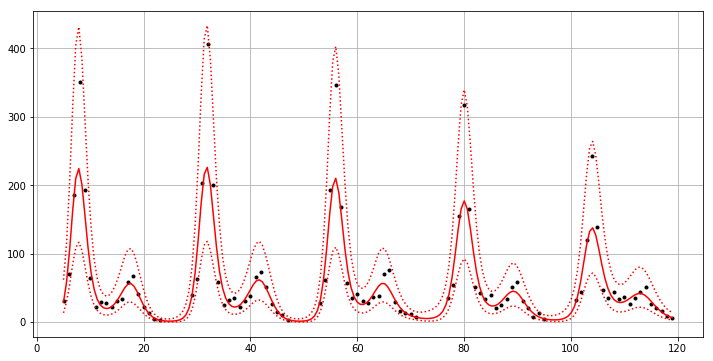

In [14]:
tf.reset_default_graph()

N = 20

np.random.seed(0)

input_data = bike_times
output_data = bike_counts

gp = create_poission_gp(input_data=input_data, 
                        output_data=output_data, 
                        initial_signal_variance=1.0,
                        initial_lengthscale=1.0,
                        initial_sigma_noise_sq=1.0,
                       initial_bound_mean=tf.log(output_data.astype(float)),
                       initial_bound_variance=1.0 )

with tf.Session() as session:
    feed_dict = {}

    t_objective = gp.t_objective
    learning_rate = 0.1
    num_iterations = 2000

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(t_objective)
    
    session.run(tf.global_variables_initializer())
    
    print('Before Optimisation:')
    print_hyperparameters(gp, session)

    refresh_iter = int(np.ceil(num_iterations / 10))
    for i in range(num_iterations):
        opt, cost = session.run((optimizer, t_objective),
                                feed_dict=feed_dict)
        if (i % refresh_iter) == 0:
            print('  opt iter {:5}: objective = {}'.format(i, cost))

    print('Final iter {:5}: objective = {}\n'.format(i, cost))
    
    print('After Optimisation:')
    print_hyperparameters(gp, session)
    
    input_values = np.linspace(np.min(input_data), np.max(input_data), 200)
    plot_gp_predictions1(gp, session, input_values)

# Periodic Kernel

In [15]:
def create_periodic_kernel(t_X1, t_X2, t_signal_variance, t_gamma, t_period):
    xx = tf.reduce_sum(t_X1 * t_X1, axis=1, keep_dims=True)
    zz = tf.reduce_sum(t_X2 * t_X2, axis=1, keep_dims=True)
    input_square = xx + tf.transpose(zz) - 2.0 *  tf.matmul(t_X1, t_X2, transpose_b=True)
    
    re_period = np.pi / t_period
    sin_inner = re_period * tf.sqrt(input_square)
    sin2 = tf.square(tf.sin(sin_inner))

    return t_signal_variance * tf.exp(- 2 * t_gamma * sin2)

# Modify this function as appropriate..
def create_periodic_gp(input_data, 
                       output_data, 
                       initial_signal_variance,
                       initial_gamma,
                       initial_period,
                       initial_sigma_noise_sq,
                       initial_bound_mean,
                       initial_bound_variance):

    # Constant training data in tensorflow
    t_X = tf.constant(input_data, dtype=dtype)
    t_Y = tf.constant(output_data, dtype=dtype)

    t_N = tf.shape(t_Y)[0]
    t_D = tf.shape(t_Y)[1]
    t_Q = tf.shape(t_X)[1]
    jitter = 1.0e-8

    # Create variables for hyperparamers
    t_signal_variance = create_positive_variable(initial_signal_variance)
    t_gamma = create_positive_variable(initial_gamma)
    t_period = create_positive_variable(initial_period)
#     t_lengthscale = create_positive_variable(initial_lengthscale)
    t_sigma_noise_sq = create_positive_variable(initial_sigma_noise_sq)
    
    # since mean n can be negative and positive, given t_bound_mean for real value of initial_bound_mean.
    # given variance positive value of initial_bound_variance
    t_bound_mean = create_real_variable(initial_bound_mean)
    t_bound_variance = create_positive_variable(initial_bound_variance)
    
    hyperparameter_dict = {'signal_variance': t_signal_variance,
                           'gamma': t_gamma,
                           't_period':t_period,
                           'sigma_noise_squared': t_sigma_noise_sq}
#                           'initial_bound_mean':initial_bound_mean,
#                        'initial_bound_variance':initial_bound_variance} # variance 
    
    # Create a lambda function to ensure we use the same hyperparameters
    # when be create the different kernels..
    kernel_creation_function = lambda t_X1, t_X2: \
        create_periodic_kernel(t_X1=t_X1, 
                                  t_X2=t_X2,
                                  t_gamma = t_gamma, 
                                  t_period = t_period,
                                  t_signal_variance=t_signal_variance)

    # Create the training data covariance matrix + noise identity matrix
    #
    # NOTE: We include the jitter term to improve nummerical stability
    #
    t_K_xx = kernel_creation_function(t_X1=t_X, t_X2=t_X) \
        + (t_sigma_noise_sq + jitter) * tf.eye(t_N, dtype=dtype)

    # Take the cholesky decomposition of K = L L^T to make it easy to calculate 
    # the inverse of K and the log determinant of K. This relies on K being a 
    # positive definite covariance matrix.
    
#     t_L_matrix = tf.cholesky(t_K_matrix + jitter * tf.eye(tf.shape(t_K_matrix)[0], dtype=dtype))
    t_L_xx = tf.cholesky(t_K_xx)
                             
    t_sigma_matrix= (t_bound_variance + jitter) * tf.eye(t_N, dtype=dtype) 
#     t_ksigma2_matrix = tf.cholesky_solve(t_L_matrix, t_sigma_matrix) 
    t_Kinv_sigma2transpose = tf.trace(tf.cholesky_solve(t_L_xx, t_sigma_matrix))

#     t_L_xx = tf.cholesky(t_K_xx)
    t_Kinv_mutranspose = tf.reduce_sum(tf.square(
        tf.matrix_triangular_solve(t_L_xx, t_bound_mean, lower=True)))             

    # The log determinant of K is twice the sum of the log of the diagonal of the
    # cholesky matrix
    t_log_det = 2.0 * tf.reduce_sum(tf.log(tf.diag_part(t_L_xx)))

    # We can calculate the data fit term by using the cholesky matrix L to
    # invert the covariance matrix efficiently using the matrix triangular solve
    # operation. 
    #
#     Tr[K^-1 Y Y^T] = Tr[Y^T (L L^T)^-1 Y] = Tr[(Y^T L^-T) (L^-1 Y)] = sum((L^-1 Y)^2)
    #
    t_Kinv_YYtranspose = 0.5 * tf.reduce_sum(tf.square(
        tf.matrix_triangular_solve(t_L_xx, t_Y, lower=True)))

    # Add a loose prior on the noise variance
    t_noise_prior = + 0.5 * tf.square(tf.log(t_sigma_noise_sq))
    
    # Add loose priors on the kernel hyperparameters
    t_hyper_prior = + 0.5 * tf.square(tf.log(t_signal_variance)) \
                    + 0.5 * tf.square(tf.log(t_gamma)) \
                    + 0.5 * tf.square(tf.log(t_period))

    half_log_two_pi = tf.constant(0.5 * np.log(2.0 * np.pi), dtype=dtype)
                             
    
                             
    part_one = tf.reduce_sum(t_Y * t_bound_mean - tf.exp((2 * t_bound_mean + t_bound_variance) / 2))                     
    part_two = 0.5 * (t_Kinv_sigma2transpose + t_Kinv_mutranspose - dtype_convert(t_N) + t_log_det - dtype_convert(t_N) * tf.log(t_bound_variance) )              
    
                             
    t_lower_bound = -(part_one - part_two)

    # Evaluate the NEGATIVE (since we will minimise) marginal log likelihood as
    # the objective for training the hyperparameters
#     t_neg_log_likelihood = half_log_two_pi * dtype_convert(t_D) * dtype_convert(t_N) \
#                          + 0.5 * dtype_convert(t_D) * t_log_det \
#                          + t_Kinv_YYtranspose + t_hyper_prior + t_noise_prior

    def create_prediction(tf_input):
        # Invert using the cholesky decomposition of the kernel
        t_Kinv_Y = tf.cholesky_solve(t_L_xx, initial_bound_mean)
        
        # Calculate the kernel from the input to the training data
        t_K_x_X = kernel_creation_function(t_X1=tf_input, t_X2=t_X)
        
        # Get the predicitive mean
        t_y_mean = tf.matmul(t_K_x_X, t_Kinv_Y) #*tf.exp(t_bound_mean)
        
        t_K_x_x_diag = tf.diag_part(kernel_creation_function(t_X1=tf_input, t_X2=tf_input)) \
            + t_sigma_noise_sq * tf.ones([tf.shape(tf_input)[0]], dtype=dtype)

        # Get the predicitve variance
        t_y_var = t_K_x_x_diag - tf.reduce_sum(tf.square(
            tf.matrix_triangular_solve(t_L_xx, tf.transpose(t_K_x_X))), axis=0)
        
        # Make sure a N* x 1 matrix (where N* = number of test inputs)
        t_y_var = t_y_var[:, tf.newaxis]

        # Return the predicitve mean and variance
        return t_y_mean, t_y_var

    # A placeholder for providing different test data after training. See the introduction
    # to tensorflow for details on how the placeholders work
    t_prediction_placeholder = tf.placeholder(dtype=dtype)
    t_prediction_mean, t_prediction_var = create_prediction(t_prediction_placeholder)

    gp = GP(description='Periodic Gaussian Process',
            t_objective=t_lower_bound,
            create_prediction_function=create_prediction,
            t_prediction_placeholder=t_prediction_placeholder,
            t_prediction_mean=t_prediction_mean,
            t_prediction_var=t_prediction_var,
            t_input=t_X,
            t_output=t_Y,
            hyperparameter_dict=hyperparameter_dict)

    return gp

In [16]:
# Plot the predicitve posterior for the provide input values (num_test_points x 1 matrix) 
def plot_gp_predictions1(gp, session, input_values):
    # Ensure N* x 1 input variable
    if input_values.ndim == 1:
        input_values = input_values[:,np.newaxis]
    
    feed_dict = {gp.t_prediction_placeholder: input_values}
    
    pred_mean, pred_var = session.run((gp.t_prediction_mean, 
                                       gp.t_prediction_var), 
                                      feed_dict=feed_dict)
    
    plt.figure(figsize=[12,6])
    plt.plot(session.run(gp.t_input), session.run(gp.t_output), 'k.')
    plt.plot(input_values, np.exp(pred_mean), 'r-')
    plt.plot(input_values, np.exp(pred_mean + 2.0 * np.sqrt(pred_var)), 'r:')
    plt.plot(input_values, np.exp(pred_mean - 2.0 * np.sqrt(pred_var)), 'r:')
    plt.grid(True)


Before Optimisation:
signal_variance = 1.0
gamma = 1.0
t_period = 24.0
sigma_noise_squared = 1.0

  opt iter     0: objective = -18661.565653156944
  opt iter   200: objective = -22555.149871144917
  opt iter   400: objective = -22533.92461960385
  opt iter   600: objective = -22573.19051198674
  opt iter   800: objective = -22565.1548567097
  opt iter  1000: objective = -22500.596835292254
  opt iter  1200: objective = -22467.375968878798
  opt iter  1400: objective = -22573.609729619657
  opt iter  1600: objective = -22571.428522167273
  opt iter  1800: objective = -22574.62044508707
Final iter  1999: objective = -22571.334584287924

After Optimisation:
signal_variance = 8.11173
gamma = 1.93806
t_period = 24.0343
sigma_noise_squared = 0.023998



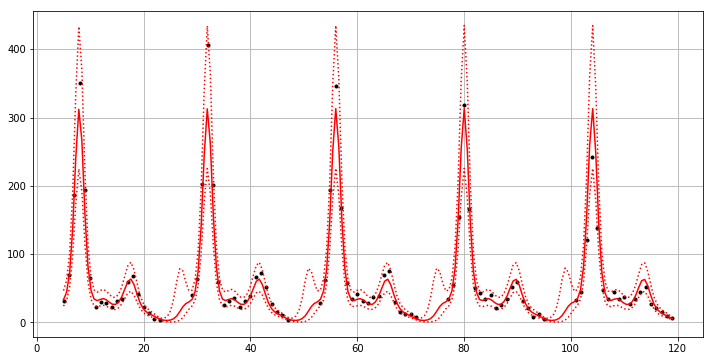

In [17]:
tf.reset_default_graph()

N = 20

np.random.seed(0)

input_data = bike_times
output_data = bike_counts

gp = create_periodic_gp(input_data=input_data, 
                        output_data=output_data, 
                        initial_signal_variance=1.0,
                        initial_gamma=1.0,
                        initial_period=24.0,
                        initial_sigma_noise_sq=1.0,
                       initial_bound_mean=tf.log(output_data.astype(float)),
                       initial_bound_variance=1.0 )

with tf.Session() as session:
    feed_dict = {}

    t_objective = gp.t_objective
    learning_rate = 0.1
    num_iterations = 2000

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(t_objective)
    
    session.run(tf.global_variables_initializer())
    
    print('Before Optimisation:')
    print_hyperparameters(gp, session)

    refresh_iter = int(np.ceil(num_iterations / 10))
    for i in range(num_iterations):
        opt, cost = session.run((optimizer, t_objective),
                                feed_dict=feed_dict)
        if (i % refresh_iter) == 0:
            print('  opt iter {:5}: objective = {}'.format(i, cost))

    print('Final iter {:5}: objective = {}\n'.format(i, cost))
    
    print('After Optimisation:')
    print_hyperparameters(gp, session)
    
    input_values = np.linspace(np.min(input_data), np.max(input_data), 200)
    plot_gp_predictions1(gp, session, input_values)

**Comments:**

Cause in many cases, the meta data do not following Gaussian likelihoods, such as data based on counts,which is this lab case, the traffic count data based on the 24 hours time period. we can evaluate the marginal log-likelihood that make the maximise the lower bound L for approximating distribution wrt the variational parameters of posterior q(f).

The latent function f plays the role of a nuisance function,The purpose of f is solely to allow a convenient formulation of the model. According to the given function $\lambda(f(x)) $, this can get new perdict value after calculation.Moreover, introduce an independent noise to the latent process in combination with a step-function likelihood as $\lambda(f_n) = \exp(f_n) $, this function can reduce the negative value,inrease the range of the positive prediction error. The use of this prior matches this problem, fixing the deficiency of the log likelihood function. The possion distribution is defined as modelling the number of times an event occurs in an interval of time, and at this case the interval of time is each hour. so this model can get better predictions than GP process. finally, this computation of predictions is straightforward as relevant integrals(proved aboved).